In [125]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from simulation import simulate_emission_quadratic, simulate_log_damage
from scipy.interpolate import make_interp_spline
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

np.random.seed(0)

# defaultColors = ['#1f77b4',  ## muted blue
#                 '#ff7f0e',  ## safety orange
#                 '#2ca02c',  ## cooked asparagus green
#                 '#d62728',  ## brick red
#                 '#9467bd',  ## muted purple
#                 '#8c564b',  ## chestnut brown
#                 '#e377c2',  ## raspberry yogurt pink
#                 '#7f7f7f',  ## middle gray
#                 '#bcbd22',  ## curry yellow-green
#                 '#17becf'   ## blue-teal
#                 ]

In [2]:
# Model parameters
δ = 0.01
η = 0.032
median = 1.75/1000
h_hat = 0.2
σ_n = 1.5
γ_low = 0.012
γ_high = 0.024
ξ = σ_n/h_hat*δ*η

# Simulation setting
r_start = 1500
T = 300

## 1. Figure 3 and 4

In [3]:
# Simulate emission trajectory
args_trace_ϕ = (-20, -5, 3000, 1e-9, 1e-3)
Et_low, r_grid_low, _, e_grid_low  = simulate_emission_quadratic(δ, η, median*γ_low, ξ, σ_n=0, # Replace σ_n with 0 if you want to set τ_2 = 0.
                                     args_trace_ϕ=args_trace_ϕ,
                                     r_start=r_start, T=T)
Et_high, r_grid_high, _, e_grid_high = simulate_emission_quadratic(δ, η, median*γ_high, ξ, σ_n=0,
                                      args_trace_ϕ=args_trace_ϕ,
                                      r_start=r_start, T=T)

In [102]:
# # Figure 3
# fig = go.Figure()
# fig.add_trace(go.Scatter(y=Et_high,
#                     mode='lines',
#                     name=r'$\gamma=0.024$',
#                     line=dict(width=3, color=defaultColors[0])))
# fig.add_trace(go.Scatter(y=Et_low,
#                     mode='lines',
#                     name=r'$\gamma=0.012$',
#                     line=dict(width=3, color=defaultColors[1])))
# fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
#                   plot_bgcolor='rgba(0,0,0,0)',
#                   width=800,
#                   height=500,
#                   legend=dict(yanchor="top",
#                               y=1,
#                               xanchor="right",
#                               x=1)
#                  )
# fig.update_xaxes(showline=True, linewidth=2, linecolor='black', title_text='Year', range=[0,T])
# fig.update_yaxes(showline=True, linewidth=2, linecolor='black', title_text='Emission', range=[0,10])
                  
# fig.write_image("emissions_trajectory.png")
# fig.show()

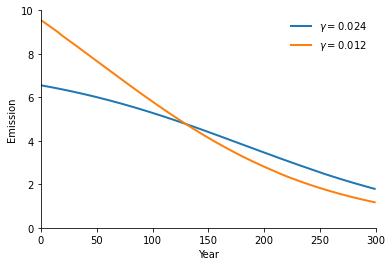

In [126]:
plt.plot(Et_high, linewidth=2, label=r'$\gamma=0.024$')
plt.plot(Et_low, linewidth=2, label=r'$\gamma=0.012$')
plt.xlim(0,T)
plt.ylim(0,10)
plt.xlabel('Year')
plt.ylabel('Emission')
plt.legend(frameon=False)
plt.savefig('emissions_trajectory.png', dpi = 1200)
plt.show()

In [107]:
# # Figure 4
# fig = go.Figure()
# fig.add_trace(go.Scatter(y=r_start - Et_high.cumsum(),
#                     mode='lines',
#                     name=r'$\gamma=0.024$',
#                     line=dict(width=3, color=defaultColors[0])))
# fig.add_trace(go.Scatter(y=r_start - Et_low.cumsum(),
#                     mode='lines',
#                     name=r'$\gamma=0.012$',
#                     line=dict(width=3, color=defaultColors[1])))
# fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
#                   plot_bgcolor='rgba(0,0,0,0)',
#                   width=800,
#                   height=500,
#                   legend=dict(yanchor="top",
#                               y=1,
#                               xanchor="right",
#                               x=1)
#                  )
# fig.update_xaxes(showline=True, linewidth=2, linecolor='black', title_text='Year', range=[0,T])
# fig.update_yaxes(showline=True, linewidth=2, linecolor='black', title_text='Reserve', range=[0,1600])

# fig.write_image("reserve_trajectory.png")
# fig.show()

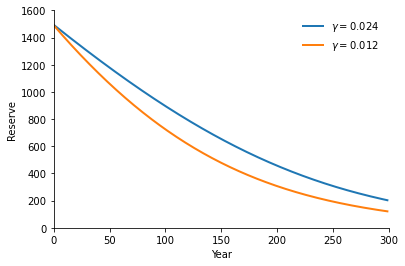

In [127]:
plt.plot(r_start - Et_high.cumsum(), linewidth=2, label=r'$\gamma=0.024$')
plt.plot(r_start - Et_low.cumsum(), linewidth=2, label=r'$\gamma=0.012$')
plt.xlim(0,T)
plt.ylim(0,1600)
plt.xlabel('Year')
plt.ylabel('Reserve')
plt.legend(frameon=False)
plt.savefig('reserve_trajectory.png', dpi = 1200)
plt.show()

## 2. Figure 5 and 6

In [6]:
# Simulate emission trajectory, 1x ξ
args_trace_ϕ = (-20, -5, 3000, 1e-9, 1e-3)
Et_low_1x, r_grid_low_1x, _, e_grid_low_1x = simulate_emission_quadratic(δ, η, median*γ_low, ξ, σ_n,
                                     args_trace_ϕ=args_trace_ϕ,
                                     r_start=r_start, T=T)
Et_high_1x, r_grid_high_1x, _, e_grid_high_1x  = simulate_emission_quadratic(δ, η, median*γ_high, ξ, σ_n,
                                      args_trace_ϕ=args_trace_ϕ,
                                      r_start=r_start, T=T)

# Simulate emission trajectory, 0.5x ξ
args_trace_ϕ = (-20, -5, 3000, 1e-9, 1e-3)
Et_low_05x, r_grid_low_05x, _, e_grid_low_05x = simulate_emission_quadratic(δ, η, median*γ_low, ξ*0.5, σ_n,
                                     args_trace_ϕ=args_trace_ϕ,
                                     r_start=r_start, T=T)
Et_high_05x, r_grid_high_05x, _, e_grid_high_05x  = simulate_emission_quadratic(δ, η, median*γ_high, ξ*0.5, σ_n,
                                      args_trace_ϕ=args_trace_ϕ,
                                      r_start=r_start, T=T)

In [7]:
h_hat_implied_low_1x = Et_low_1x*(median*γ_low)*σ_n/ξ
h_hat_implied_low_05x = Et_low_05x*(median*γ_low)*σ_n/(ξ*0.5)

h_hat_implied_high_1x = Et_high_1x*(median*γ_high)*σ_n/ξ
h_hat_implied_high_05x = Et_high_05x*(median*γ_high)*σ_n/(ξ*0.5)

In [112]:
# # Figure 5
# fig = go.Figure()
# fig.add_trace(go.Scatter(y=Et_high_1x,
#                     mode='lines',
#                     name=r'$\gamma=0.024$',
#                     line=dict(width=3, color=defaultColors[0])))
# fig.add_trace(go.Scatter(y=Et_low_1x,
#                     mode='lines',
#                     name=r'$\gamma=0.012$',
#                     line=dict(width=3, color=defaultColors[1])))

# fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
#                   plot_bgcolor='rgba(0,0,0,0)',
#                   width=800,
#                   height=500,
#                   legend=dict(yanchor="top",
#                               y=1,
#                               xanchor="right",
#                               x=1)
#                  )
# fig.update_xaxes(showline=True, linewidth=2, linecolor='black', title_text='Year', range=[0,T])
# fig.update_yaxes(showline=True, linewidth=2, linecolor='black', title_text='Emission', range=[0,10])

# fig.write_image("emission_300years.pdf")
# fig.show()

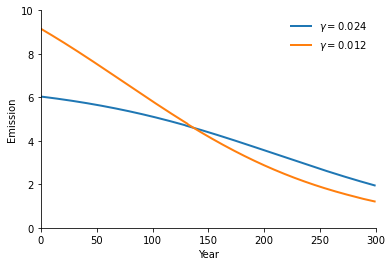

In [128]:
plt.plot(Et_high_1x, linewidth=2, label=r'$\gamma=0.024$')
plt.plot(Et_low_1x, linewidth=2, label=r'$\gamma=0.012$')
plt.xlim(0,T)
plt.ylim(0,10)
plt.xlabel('Year')
plt.ylabel('Emission')
plt.legend(frameon=False)
plt.savefig('emission_300years.png', dpi = 1200)
plt.show()

In [119]:
# # Figure 6
# fig = go.Figure()
# fig.add_trace(go.Scatter(y=h_hat_implied_high_1x,
#                     mode='lines',
#                     name=r'$\xi=0.0024, \gamma=0.024$',
#                     line=dict(width=3, color=defaultColors[0])))
# fig.add_trace(go.Scatter(y=h_hat_implied_high_05x,
#                     mode='lines',
#                     name=r'$\xi=0.0012, \gamma=0.024$',
#                     line=dict(width=3, color=defaultColors[1])))

# fig.add_trace(go.Scatter(y=h_hat_implied_low_1x,
#                     mode='lines',
#                     name=r'$\xi=0.0024, \gamma=0.012$',
#                     line=dict(width=3, color=defaultColors[0], dash='dash')))
# fig.add_trace(go.Scatter(y=h_hat_implied_low_05x,
#                     mode='lines',
#                     name=r'$\xi=0.0012, \gamma=0.012$',
#                     line=dict(width=3, color=defaultColors[1], dash='dash')))

# fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
#                   plot_bgcolor='rgba(0,0,0,0)',
#                   width=800,
#                   height=500,
#                   legend=dict(yanchor="top",
#                               y=1,
#                               xanchor="right",
#                               x=1)
#                  )
# fig.update_xaxes(showline=True, linewidth=2, linecolor='black', title_text='Year', range=[0,T])
# fig.update_yaxes(showline=True, linewidth=2, linecolor='black', title_text=r'$h^*$', range=[0, 0.3])

# fig.write_image("hat_h_300years.pdf")
# fig.show()

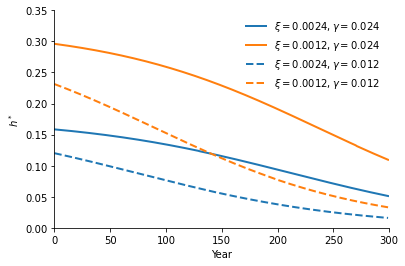

In [129]:
plt.plot(h_hat_implied_high_1x, linewidth=2, label=r'$\xi=0.0024, \gamma=0.024$', color=defaultColors[0])
plt.plot(h_hat_implied_high_05x, linewidth=2, label=r'$\xi=0.0012, \gamma=0.024$', color=defaultColors[1])
plt.plot(h_hat_implied_low_1x, linewidth=2, label=r'$\xi=0.0024, \gamma=0.012$', linestyle='dashed', color=defaultColors[0])
plt.plot(h_hat_implied_low_05x, linewidth=2, label=r'$\xi=0.0012, \gamma=0.012$', linestyle='dashed', color=defaultColors[1])
plt.xlim(0,T)
plt.ylim(0,0.35)
plt.xlabel('Year')
plt.ylabel(r'$h^*$')
plt.legend(frameon=False)
plt.savefig('hat_h_300years.png', dpi = 1200)
plt.show()

## 3. Table 1

In [10]:
# Table for e_tilde
def e_tilde_fun(ξ, γ, median=1.75/1000, σ_n=1.5, δ=0.01, η=0.032):
    τ_1 = γ*median
    τ_2 = (τ_1**2) * (σ_n**2) / (2*ξ)
    if τ_2 == 0:
        res = δ*η/τ_1
    else:
        res = (-τ_1 + np.sqrt(τ_1**2 + 4*δ*η*τ_2)) / (2*τ_2)
    return res

e_tilde_low_0 = e_tilde_fun(ξ, γ_low, σ_n=0)
e_tilde_low = e_tilde_fun(ξ, γ_low)
e_tilde_low_01x = e_tilde_fun(ξ*0.1, γ_low)
e_tilde_low_05x = e_tilde_fun(ξ*0.5, γ_low)
e_tilde_low_5x = e_tilde_fun(ξ*5, γ_low)
e_tilde_low_10x = e_tilde_fun(ξ*10, γ_low)

e_tilde_high_0 = e_tilde_fun(ξ, γ_high, σ_n=0)
e_tilde_high = e_tilde_fun(ξ, γ_high)
e_tilde_high_01x = e_tilde_fun(ξ*0.1, γ_high)
e_tilde_high_05x = e_tilde_fun(ξ*0.5, γ_high)
e_tilde_high_5x = e_tilde_fun(ξ*5, γ_high)
e_tilde_high_10x = e_tilde_fun(ξ*10, γ_high)

df = pd.DataFrame([[e_tilde_low_05x, e_tilde_low, e_tilde_low_0],
                   [e_tilde_high_05x, e_tilde_high, e_tilde_high_0]])
df.index = ['γ = 0.012', 'γ = 0.024']
df.columns = ['0.5x ξ', '1x ξ', 'τ_2 = 0']
df

,0.5x ξ,1x ξ,τ_2 = 0
γ = 0.012,12.272754,13.4558,15.238095
γ = 0.024,6.136377,6.7279,7.619048


## 4. Table 2

In [11]:
# Simulate damages
exp_avg_response_low = median * γ_low / (1-η)
exp_avg_response_high = median * γ_high / (1-η)
Ws = np.random.normal(0., 1., (1_000_000, T))
log_damage_low = simulate_log_damage(exp_avg_response_low, σ_n, Et_low_1x, Ws)
log_damage_high = simulate_log_damage(exp_avg_response_high, σ_n, Et_high_1x, Ws)

In [12]:
low_50 = log_damage_low[:, 50-1] / Et_low_1x[:50].sum() / γ_low * 1000
low_100 = log_damage_low[:, 100-1] / Et_low_1x[:100].sum() / γ_low * 1000
low_200 = log_damage_low[:, 200-1] / Et_low_1x[:200].sum() / γ_low * 1000

high_50 = log_damage_high[:, 50-1] / Et_high_1x[:50].sum() / γ_high * 1000
high_100 = log_damage_high[:, 100-1] / Et_high_1x[:100].sum() / γ_high * 1000
high_200 = log_damage_high[:, 200-1] / Et_high_1x[:200].sum() / γ_high * 1000

In [24]:
print('50 years:', exp_avg_response_low * np.sqrt(np.sum(Et_low_1x[: 50]**2)) * σ_n / Et_low_1x[:50].sum() / γ_low * 1000)
print('100 years:', exp_avg_response_low * np.sqrt(np.sum(Et_low_1x[: 100]**2)) * σ_n / Et_low_1x[:100].sum() / γ_low * 1000)
print('200 years:', exp_avg_response_low * np.sqrt(np.sum(Et_low_1x[: 200]**2)) * σ_n / Et_low_1x[:200].sum() / γ_low * 1000)

50 years: 0.38409828430453635
100 years: 0.273420245509514
200 years: 0.20120167801473948


In [25]:
print('50 years:', exp_avg_response_high * np.sqrt(np.sum(Et_high_1x[: 50]**2)) * σ_n / Et_high_1x[:50].sum() / γ_high * 1000)
print('100 years:', exp_avg_response_high * np.sqrt(np.sum(Et_high_1x[: 100]**2)) * σ_n / Et_high_1x[:100].sum() / γ_high * 1000)
print('200 years:', exp_avg_response_high * np.sqrt(np.sum(Et_high_1x[: 200]**2)) * σ_n / Et_high_1x[:200].sum() / γ_high * 1000)

50 years: 0.3835708464254778
100 years: 0.27148040922263256
200 years: 0.19374287333726195


In [28]:
# Quasi-anlaytical for std
0.3841 / np.sqrt(2)

0.2715997146537529

0.3835708464254778

In [29]:
# low damage
n_path = 25
T_plots = 100
res_low = np.zeros((n_path, T_plots))
for i in range(T_plots):
    temp = log_damage_low[:n_path, i] / Et_low_1x[:i+1].sum() / γ_low * 1000
    res_low[:, i] = temp
    
res_high = np.zeros((n_path, T_plots))
for i in range(T_plots):
    temp = log_damage_high[:n_path, i] / Et_high_1x[:i+1].sum() / γ_low * 1000
    res_high[:, i] = temp

In [130]:
# # Figure 6
# fig = go.Figure()

# for i in range(n_path):
#     fig.add_trace(go.Scatter(y=res_low[i, :],
#                         mode='lines'))

# fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
#                   plot_bgcolor='rgba(0,0,0,0)',
#                   width=800,
#                   height=500,
#                   legend=dict(yanchor="top",
#                               y=1,
#                               xanchor="right",
#                               x=1)
#                  )
# fig.update_xaxes(showline=True, linewidth=2, linecolor='black', title_text='Year', range=[0,100])
# fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

# fig.update_layout(showlegend=False)

# fig.write_image("25_path_low_damage.pdf")
# fig.show()

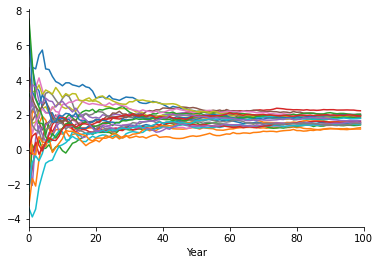

In [131]:
for i in range(n_path):
    plt.plot(res_low[i, :])
plt.xlim(0,100)
plt.xlabel('Year')
plt.savefig('25_path_low_damage.png', dpi = 1200)
plt.show()

In [132]:
# # Figure 8
# fig = go.Figure()

# for i in range(n_path):
#     fig.add_trace(go.Scatter(y=res_high[i, :],
#                         mode='lines'))

# fig.update_layout(paper_bgcolor='rgba(0,0,0,0)',
#                   plot_bgcolor='rgba(0,0,0,0)',
#                   width=800,
#                   height=500,
#                   legend=dict(yanchor="top",
#                               y=1,
#                               xanchor="right",
#                               x=1)
#                  )
# fig.update_xaxes(showline=True, linewidth=2, linecolor='black', title_text='Year', range=[0,100])
# fig.update_yaxes(showline=True, linewidth=2, linecolor='black')

# fig.update_layout(showlegend=False)

# fig.write_image("25_path_high_damage.pdf")
# fig.show()

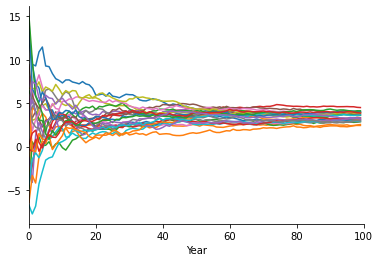

In [133]:
for i in range(n_path):
    plt.plot(res_high[i, :])
plt.xlim(0,100)
plt.xlabel('Year')
plt.savefig('25_path_high_damage.png', dpi = 1200)
plt.show()